In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rediscovery_rate
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Old data frame

In [2]:
fpath = '../../results/2021-12-02-proximity-various-ADgenesets/merged-proximity-chembl.csv'
usecols = range(6)
merged = pd.read_csv(fpath, index_col=0, skiprows=1, usecols=usecols).rename_axis('drug_chembl_id', axis=0)
fpath = '../../results/2021-12-02-proximity-various-ADgenesets/merged-proximity-chembl.csv'
sel_gsets = ['knowledge', 'TWAS2+', 'agora2+', 'AD DE APOE3-APOE3', 'AD DE APOE4-APOE4', 'APOE3-4 DE neuron', 'APOE3-4 DE astrocyte', 'APOE3-4 DE microglia']
merged_ranks = pd.read_csv(fpath, index_col=0, header=[0, 1]).rename_axis('drug_chembl_id', axis=0).xs('rank', axis=1, level=1)[sel_gsets]
fpath = '../../results/2021-12-13-chembl-drug-info/drug-indication.csv'
indications = pd.read_csv(fpath, index_col='drug_chembl_id')
# D000544 is Alzheimer disease
mp4ad = indications.loc[indications.mesh_id == 'D000544', ['max_phase_for_ind']].rename({'max_phase_for_ind': 'max_phase_for_AD'}, axis=1)
fpath = '../../results/2021-12-13-chembl-drug-info/drug-info-bbb.csv'
info_bbb = pd.read_csv(fpath, index_col=0).drop(['drug_name'], axis=1)
fpath = '../../results/2022-01-14-rank-aggregation/aggregated-ranks.csv'
agg_ranks = pd.read_csv(fpath, index_col='rank')
top_drugs = pd.DataFrame({'aggregate rank': agg_ranks.index}, index=agg_ranks.MC3).rename_axis('drug_chembl_id', axis=0)
drugs = pd.merge(merged, info_bbb, how='left', on='drug_chembl_id')
drugs = pd.merge(drugs, mp4ad, how='left', on='drug_chembl_id')
drugs = pd.merge(drugs, top_drugs, how='left', on='drug_chembl_id')
drugs = pd.merge(drugs, merged_ranks, how='left', on='drug_chembl_id')
drugs = drugs.sort_values('aggregate rank')

## New data frames

In [3]:
drugs_rmta = rediscovery_rate.make_drugs_df(screenpath='../../results/proximity-runs/rmta-apoe3-apoe4/rmta-apoe3-apoe4.csv', sort_by_z=True)

In [4]:
drugs_aggreg = rediscovery_rate.make_drugs_df(screenpath='../../results/2021-12-02-proximity-various-ADgenesets/merged-proximity-chembl.csv', sort_by_z=False)
fpath = '../../results/2022-01-14-rank-aggregation/aggregated-ranks.csv'
agg_ranks = pd.read_csv(fpath, index_col='rank')
top_drugs = pd.DataFrame({'aggregate rank': agg_ranks.index}, index=agg_ranks.MC3).rename_axis('drug_chembl_id', axis=0)
drugs_aggreg = pd.merge(drugs_aggreg, top_drugs, how='left', on='drug_chembl_id')
drugs_aggreg = drugs_aggreg.sort_values('aggregate rank')

## Testing

This section reproduces earlier results (see [2022-01-14-top-drugs](https://github.com/attilagk/CTNS-notebook/blob/main/2022-01-14-top-drugs/2022-01-14-top-drugs.ipynb))

In [5]:
def top_bottom(drugs=drugs, topk=100, min_max_phase_for_ind=1, ind_col='max_phase_for_AD'):
    bottoml = drugs['aggregate rank'].count()
    #bottomk = len(drugs) - topk
    df = drugs.copy()
    df['tested4AD'] = drugs[ind_col] >= min_max_phase_for_ind
    top = df.iloc[:topk]
    bottom = df.iloc[-bottoml:]
    top_avg, bottom_avg = [df.loc[df['tested4AD'], ind_col].sum() / xk for df, xk in zip([top, bottom], [topk, bottoml])]
    ratio = top_avg / bottom_avg
    return(ratio)

top_bottom(drugs), top_bottom(drugs_aggreg)

(2.8089473684210526, 2.8089473684210526)

In [6]:
rediscovery_rate.rel_rediscovery_rate(drugs, bottoml=593)

2.8089473684210526

In [7]:
rrrs = rediscovery_rate.rel_rediscovery_rates(drugs, bottoml=593)#.plot(kind='scatter', x='top-t', y='rel rediscovery rate')
rrrs.head()

,top-t,rel rediscovery rate
0,10,0.000000
1,20,3.121053
2,30,2.080702
3,40,2.730921
4,50,2.184737


<AxesSubplot:xlabel='top-t', ylabel='rel rediscovery rate'>

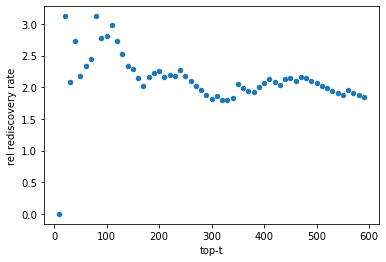

In [8]:
rrrs.plot(kind='scatter', x='top-t', y='rel rediscovery rate')

## Validation of rMTA based screen

This shows that the rMTA based ranking of ChEMBL drugs is uninformative for AD drug rediscovery since the orange line (rMTA) is close to 1.

Text(0, 0.5, 'rel rediscovery rate')

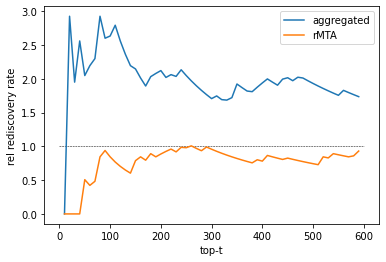

In [9]:
rrrs_rmta = rediscovery_rate.rel_rediscovery_rates(drugs_rmta, bottoml=600)
rrrs_aggreg = rediscovery_rate.rel_rediscovery_rates(drugs_aggreg, bottoml=600)
fig, ax = plt.subplots()
rrrs_aggreg.plot(kind='line', x='top-t', y='rel rediscovery rate', ax=ax, label='aggregated')
rrrs_rmta.plot(kind='line', x='top-t', y='rel rediscovery rate', ax=ax, label='rMTA')
ax.hlines(1, 0, 600, color='black', linewidth=0.5, linestyle='dashed')
ax.set_ylabel('rel rediscovery rate')

## Validation of Dilara's DrugBank drugs

Dilara discovered several drugs using DrugBank.  Below I convert DrugBank IDs to ChEMBL IDs (some are not convertable based on `chembl2drugbank.tsv` by UniChem) and some are not contained in the set of phase 3-4 ChEMBL drugs.

The analysis shows that the remaining of Dilara's drugs do not include any drug with AD indication, which gives 0 rediscovery rate.

In [10]:
inpath = '../../resources/tunahan/Drug_Target_GeneList_rMTA_APOE.xlsx'
drugbank_l = [pd.read_excel(inpath, index_col='DrugBankID', sheet_name=celltype)[['gene']] for celltype in ['neuron', 'astrocyte', 'microglia']]
drugbank_ids = list(pd.concat(drugbank_l, axis=0).index.dropna().drop_duplicates())

In [11]:
drugbank2chembl = pd.read_csv('../../resources/UniChem/chembl2drugbank.tsv', sep='\t', index_col="To src:'2'").rename({"From src:'1'": 'ChEMBL ID'}, axis=1).rename_axis(index='DrugBank ID')['ChEMBL ID']
convertable_drugbank_ids = set(drugbank_ids).intersection(set(drugbank2chembl.index))
dilara_drugs_chembl_ids = list(set(drugbank2chembl.loc[convertable_drugbank_ids].to_list()).intersection(set(drugs_rmta.index)))
drugs_rmta.loc[dilara_drugs_chembl_ids]

,drug_name,max_phase,indication_class,uniprot_name,target_name,d,avg_d_H0,sdev_d_H0,z,p,max_phase_for_AD,rank by z
drug_chembl_id,,,,,,,,,,,,
CHEMBL1543,GLUTATHIONE,3,NaN,GSTK1,Glutathione S-transferase kappa 1,2.000000,1.867000,0.342507,0.388313,0.651108,NaN,1366
CHEMBL75880,PERHEXILINE,4,Vasodilator (coronary),EGFR|FYN|ACM4|ACM5|CP2D6|ACM1|ACM3|SC6A2|KCNH2...,Epidermal growth factor receptor erbB1|Tyrosin...,2.300000,2.089200,0.150011,1.405228,0.920023,NaN,2021
CHEMBL457,GEMFIBROZIL,4,Antihyperlipidemic,GEMI|TTHY|CP2C9|SMAD3|SMN|SO1B3,Geminin|Transthyretin|Cytochrome P450 2C9|Moth...,2.000000,1.860600,0.172880,0.806338,0.789976,0.0,1736
CHEMBL1567463,CHOLINE ALFOSCERATE,3,NaN,UBP1,Ubiquitin carboxyl-terminal hydrolase 1,2.000000,1.955000,0.225776,0.199312,0.578991,NaN,1105
CHEMBL190461,CANNABIDIOL,4,NaN,CP1A1|CNR1|CNR2|GPR55,Cytochrome P450 1A1|Cannabinoid CB1 receptor|C...,3.000000,2.293333,0.272764,2.590766,0.995212,NaN,2323
CHEMBL773,GLYCINE,4,NaN,O51E2,Olfactory receptor 51E2,NaN,NaN,NaN,NaN,NaN,0.0,2424
CHEMBL513,CARMUSTINE,4,Antineoplastic,AL1A1|GSHR|THB|ARSA|PPARG|BLM|EHMT2,Aldehyde dehydrogenase 1A1|Glutathione reducta...,1.714286,1.976857,0.127276,-2.063013,0.019556,NaN,70
CHEMBL648,CYCLIZINE,4,"Anti-Emetic,Antihistaminic,Antinauseant",LX15B|ACM2|ACM4|ACM5|ADA2A|CP2D6|ACM1|ACM3|ADA...,"Arachidonate 15-lipoxygenase, type II|Muscarin...",2.333333,2.162667,0.107876,1.582056,0.943182,NaN,2097
CHEMBL472,GLYBURIDE,4,Antidiabetic,MEN1|ABCC9|SO2B1|GCR|CP3A4|CP2D6|CP2C9|TSHR|AP...,Menin/Histone-lysine N-methyltransferase MLL|S...,2.052632,2.066579,0.087830,-0.158800,0.436913,NaN,699


In [12]:
drugs_rmta.loc[dilara_drugs_chembl_ids, 'max_phase_for_AD'].sum()

0.0

In [13]:
%connect_info

{
  "shell_port": 56635,
  "iopub_port": 56636,
  "stdin_port": 56637,
  "control_port": 56639,
  "hb_port": 56638,
  "ip": "127.0.0.1",
  "key": "fdd013eb-793a5dbf4b7c272106367735",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-ef087fb0-9dab-4acf-9d0f-dcfd7d48cde6.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
